In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [16]:
import yfinance as yf
nse_ticker = "^NSEI"
# Fetch BSE data
nse_data = yf.download(nse_ticker, start="2013-01-21", end="2023-06-30")
nse_data.index = pd.DatetimeIndex(nse_data.index).to_period('D')


bse_ticker = "^BSESN"
# Fetch BSE data
bse_data = yf.download(bse_ticker, start="2004-01-01", end="2023-06-30")
bse_data.index = pd.DatetimeIndex(bse_data.index).to_period('D')

nse_data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-21,6085.750000,6094.350098,6065.100098,6082.299805,6082.299805,130900
2013-01-22,6080.149902,6101.299805,6040.500000,6048.500000,6048.500000,129000
2013-01-23,6052.850098,6069.799805,6021.149902,6054.299805,6054.299805,137000
2013-01-24,6046.200195,6065.299805,6007.850098,6019.350098,6019.350098,185200
2013-01-25,6024.500000,6080.549805,6014.450195,6074.649902,6074.649902,147600


Text(0.5, 1.0, 'BSE Closing Price')

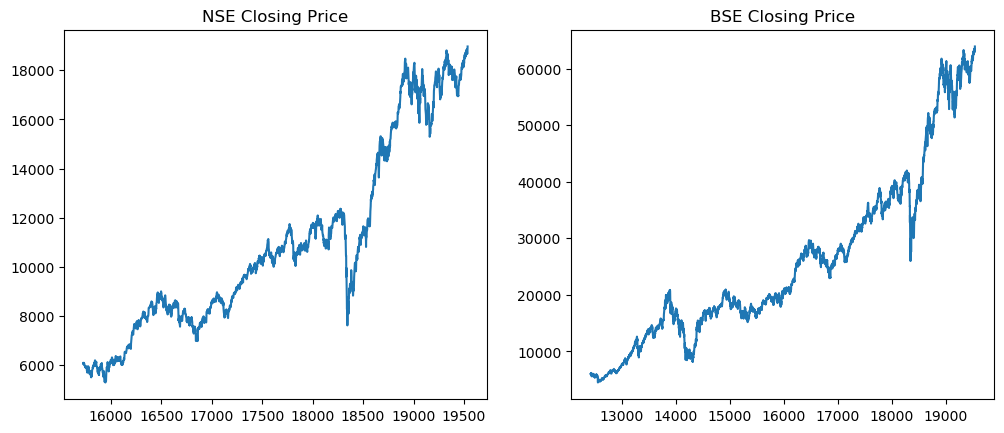

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(12)
axes[0].plot(nse_data.index, nse_data["Close"])
axes[0].set_title('NSE Closing Price')
axes[1].plot(bse_data.index, bse_data["Close"])
axes[1].set_title('BSE Closing Price')

<hr>

### Univariate Time Series Modeling:

In [18]:
predict_lag = round(0.1 * len(nse_data["Close"])) #forecase until "predict_lag" days in future

X = nse_data["Close"]
X_train = X[:-predict_lag]
X_test = X[-predict_lag:]
X_train.head()

Date
2013-01-21    6082.299805
2013-01-22    6048.500000
2013-01-23    6054.299805
2013-01-24    6019.350098
2013-01-25    6074.649902
Freq: D, Name: Close, dtype: float64

In [19]:
##naive long run model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score 

data_ = X
pred_ = np.zeros(np.shape(data_))

for i in range(len(data_)):
    if i == 0:
        pass
    pred_[i] = (data_[i-1]) + 10
print(f"Mean Absolute Error: {mae(data_[1:], pred_[1:])} \n")
print(f"R^2 Score: {r2_score(data_[1:], pred_[1:])} \n")

count = 0
direct_acc = []
for i in range(len(data_)):
    if i == 0:
        pass
    else:
        direct_acc.append(np.sign((pred_[i] - data_[i-1]) * (data_[i] - data_[i-1])) + 1)
print(f"Average Directional Accuracy: {np.mean(direct_acc) / 2} \n")


Mean Absolute Error: 79.35598752500488 

R^2 Score: 0.9990532827014821 

Average Directional Accuracy: 0.5361046057767369 



In [20]:
##raw data directional
data_ = X

count = 0
direct_acc = []
for i in range(len(data_)):
    if i == 0:
        pass
    else:
        direct_acc.append(np.sign((data_[i] - data_[i-1])) + 1)

print(f"Average Directional Accuracy: {np.mean(direct_acc) / 2} \n")

Average Directional Accuracy: 0.5361046057767369 



In [21]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score 

def plot_results(model, data, train, test, predictions_1st_step, predictions_2nd_step, title):
    
    plt.figure(figsize=(10,5))
    indices=data.index.to_timestamp()

    plt.plot(pd.Series(train[len(train)-predict_lag:].reshape(-1), index=indices[len(train)-predict_lag:len(train)]), label="truncated training data")
    plt.plot(pd.Series(test.reshape(-1), index=indices[-len(test):]), label="realised future prices")
    plt.plot(pd.Series(predictions_1st_step, index=indices[-predict_lag:]), label="predicted 1st step future prices")
    plt.legend()
    # plt.title(title)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(pd.Series(train[len(train)-predict_lag:].reshape(-1), index=indices[len(train)-predict_lag:len(train)]), label="truncated training data")
    plt.plot(pd.Series(test.reshape(-1), index=indices[-len(test):]), label="realised future prices")
    plt.plot(pd.Series(predictions_2nd_step, index=indices[-predict_lag:]), label="predicted 2nd step future prices")
    plt.legend()
    # plt.title(title)
    plt.show()

    fig = plt.figure(figsize=(4, 4))
    # ax = fig.add_subplot(111)
    resid = model.resid
    plt.plot(model.resid)

    fig = plt.figure(figsize=(4, 4))
    fig = qqplot(resid, line="q", fit=True)
    plt.ylim(-1,1)


def evaluate_model(model, data, train, test, title=None):
    model_fit = model.fit()
    
    predictions_1st_step = []
    predictions_2nd_step = []

    for t in range(len(test)):
        # Generate predictions using the model fitted on the training set
        output = model_fit
        yhat = output.predict(start=len(train) + t, end=len(train) + t + 2, dynamic=False)

        predictions_1st_step.append(yhat[0])
        predictions_2nd_step.append(yhat[1])
        
        # Update the model with the observed value without re-estimating parameters
        model_fit = model_fit.append(test[t:t+1], refit=False)
    
    print(f"R^2 Score: {r2_score(test, predictions_1st_step)} \n")
    print(f"Mean Absolute Error: {mae(test, predictions_1st_step)} \n")

    direct_acc = []
    for i in range(len(test)):
        if i == 0:
            pass
        else:
            if test[i] == test[i-1]:
                pass
            elif (predictions_1st_step[i] - test[i-1]) / (test[i] - test[i-1]) > 0:
                direct_acc.append(1)
            else:
                direct_acc.append(0)
    print(f"Average Directional Accuracy: {np.mean(direct_acc)} \n")
    
    print(model_fit.summary())

    plot_results(model_fit, data, train, test, predictions_1st_step, predictions_2nd_step, title)

    

In [22]:
##Checking for Stationarity
from sktime.datasets import load_airline
from sktime.param_est.stationarity import StationarityADFArch

sty_est = StationarityADFArch(method="aic")  #ADF test for stationarity with AIC method used for selecting length
sty_est.fit(X_train)  
sty_est.get_fitted_params()

{'stationary': False, 'test_statistic': -0.746670370901356, 'used_lag': 12}

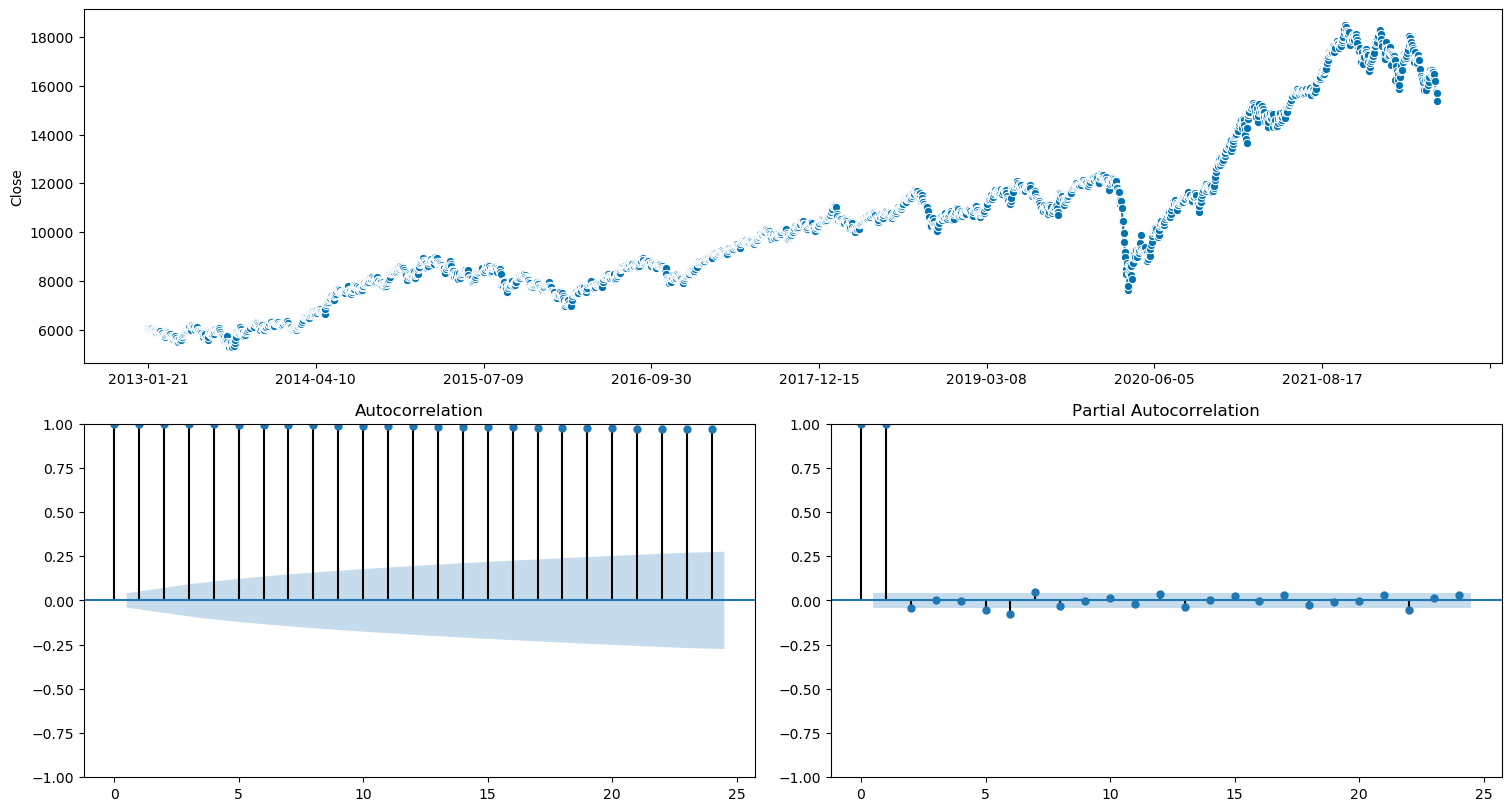

In [23]:
##Correlation Plots
from sktime.utils.plotting import plot_correlations

fig, ax = plot_correlations(X_train)
fig.set_figwidth(15)

R^2 Score: 0.9718299570733124 

Mean Absolute Error: 102.4644191894831 

Average Directional Accuracy: 0.5843137254901961 

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2563
Model:                     AutoReg(2)   Log Likelihood              -15824.653
Method:               Conditional MLE   S.D. of innovations            116.764
Date:                Mon, 13 Nov 2023   AIC                          31657.305
Time:                        17:59:37   BIC                          31680.698
Sample:                             2   HQIC                         31665.787
                                 2563                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7570      7.979      1.097      0.272      -6.882      24.396
y.L1   

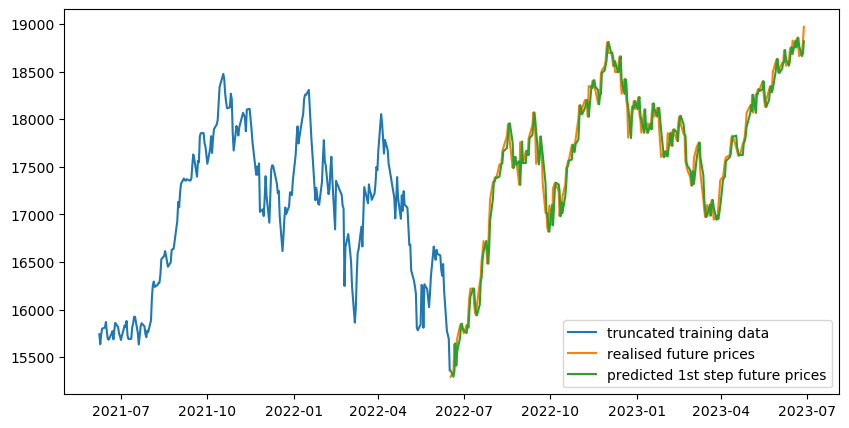

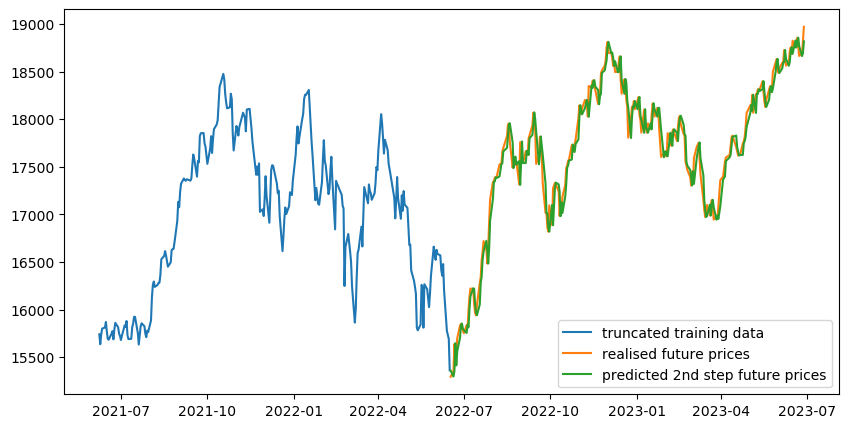

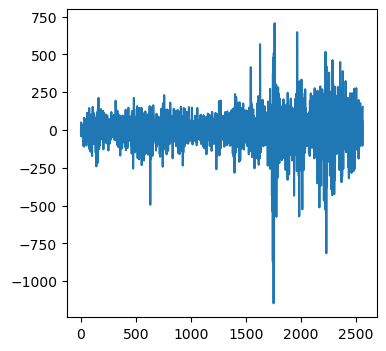

<Figure size 400x400 with 0 Axes>

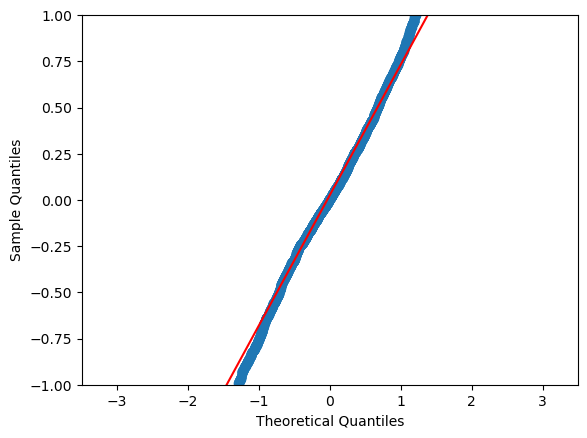

In [24]:
AR_model = AutoReg(X_train.values, lags = 2)
evaluate_model(model=AR_model, data=X, train=X_train.values, test=X_test.values, title="AR Results")

In [26]:
#Fitting ARIMA Process
from statsmodels.tsa.arima.model import ARIMA

ARIMA_model = ARIMA(X_train.values, order=(6, 1, 6))
evaluate_model(model=ARIMA_model, data=X, train=X_train.values, test=X_test.values, title="ARIMA Results")

<hr>

### Multivariate Time Series Modeling:

In [13]:
predict_lag = 20 #forecase until "predict_lag" days in future
X_nse = nse_data["Close"]
X_bse = bse_data["Close"]

X_VAR = pd.DataFrame({"NSE_Close" : X_nse, "BSE_Close" : X_bse}).dropna() #TODO: need to match dates with the univariate model so comparison is fair
X_VAR.index = pd.DatetimeIndex(X_VAR.index).to_period('D')
X_train_VAR = X_VAR[:-predict_lag]

X_train_VAR.head()

TypeError: Passing PeriodDtype data is invalid. Use `data.to_timestamp()` instead

In [173]:
def show_VAR_results(data, pred, predict_lag, title=None):
    print(f"Mean Absolute Error: {mae(pred, data[-predict_lag:].to_numpy())} \n") 
    
    plt.figure(figsize=(10,5))
    plt.plot(data[2 * -predict_lag:-predict_lag + 1], label="truncated training data")
    plt.plot(pd.Series(pred.to_numpy(), index=data[-predict_lag:].index), label="projected future prices")
    plt.plot(data[-predict_lag:], label="realised future prices")

    plt.legend()
    plt.title(title)
    plt.show()

def evaluate_VAR_model(model, data, train, predict_lag, title=None):
    if "Date" not in X_train_VAR.columns:
        model.fit(train.reset_index().drop(["Date"], axis=1))  
    else:
        model.fit(train)  

    fh_VAR = ForecastingHorizon([x for x in range(1, predict_lag + 1)]) 
    pred_VAR = model.predict(fh=fh_VAR)  

    show_VAR_results(data=data["NSE_Close"], pred=pred_VAR["NSE_Close"], predict_lag=predict_lag, title=title)

In [200]:
import numpy as np
from statsmodels.tsa.api import VAR

predict_lag = 200 #forecase until "predict_lag" days in future
X_nse = nse_data["Close"]
X_bse = bse_data["Close"]

X_VAR = pd.DataFrame({"NSE_Close" : X_nse, "BSE_Close" : X_bse}).dropna() #TODO: need to match dates with the univariate model so comparison is fair

# data = X_VAR.values.diff().dropna()
# data = np.diff(X.VAR, )
# train = data[:-predict_lag]
# test = data[-predict_lag:]

# model = VAR(train)
# model_fit = model.fit(maxlags=15, ic='aic')

# lag_order = model_fit.k_ar

# predictions_1st_step = []
# predictions_2nd_step = []

# history = train
# for t in range(len(test)):
# #     # Generate predictions using the model fitted on the training set
#     output = model_fit
#     yhat = output.forecast(history[lag_order:], steps=5)

#     predictions_1st_step.append(yhat[0])
#     predictions_2nd_step.append(yhat[1])
    
#     history = np.vstack([history, test[t]])
    # # Update the model with the observed value without re-estimating parameters
    # model_fit = model_fit.append(test[t:t+1], refit=False)
    # history = np.append(history, test[t])

# diff_series = predictions_1st_step
# undiff_series = np.zeros_like(diff_series)
# for i in range(1, len(diff_series)):
#     undiff_series[i] = undiff_series[i - 1] + diff_series[i]

# undiff_test = np.zeros_like(test)
# for i in range(1, len(test)):
#     undiff_test[i] = undiff_test[i - 1] + test[i]

# print(f"R^2 Score: {r2_score(undiff_test, undiff_series)} \n")
# print(f"Mean Absolute Error: {mae(undiff_test, undiff_series)} \n")
# direct_acc = []
# for i in range(len(test)):
#     if i == 0:
#         pass
#     else:
#         if test[i] == test[i-1]:
#             pass
#         elif (predictions_1st_step[i] - test[i-1]) / (test[i] - test[i-1]) > 0:
#             direct_acc.append(1)
#         else:
#             direct_acc.append(0)
# print(f"Average Directional Accuracy: {np.mean(direct_acc)} \n")

# print(model_fit.summary())
# print(lag_order)

# print(history)
# print(history)

# print(test)

# print(undiff_series)

In [241]:
data = np.diff(X_VAR.values, 1, axis=0)
train = data[:-predict_lag]
test_ = data[-predict_lag:]

In [249]:
model = VAR(train)
model_fit = model.fit(maxlags=15, ic='aic')
lag_order = model_fit.k_ar

In [250]:
model_fit.forecast(train[-lag_order:], steps=1)

array([[ -53.89200086, -178.57998387]])